# 3.2 ロボットの動き

## 3.2.1 世界座標系と描写

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class World :
  def __init__(self):
    self.objects = [] #ここにロボットなどのオブジェクトを登録

  def append(self, obj): #オブジェクトを登録するための関数
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(8,8)) #8*8 inchの図を準備
    ax = fig.add_subplot(111) #サブプロットを準備 111は描画の大きさかな
    ax.set_aspect('equal') #縦横比を座標の値と一致させる
    ax.set_xlim(-5,5) #x軸を-5 * 5mの範囲で描画
    ax.set_ylim(-5, 5) #y軸も同様
    ax.set_xlabel("X", fontsize=20) #X軸にラベルを表示
    ax.set_ylabel("Y", fontsize=20) #Y軸も同様

    for obj in self.objects:obj.draw(ax) #appendした物体を次々に描画

    plt.show()



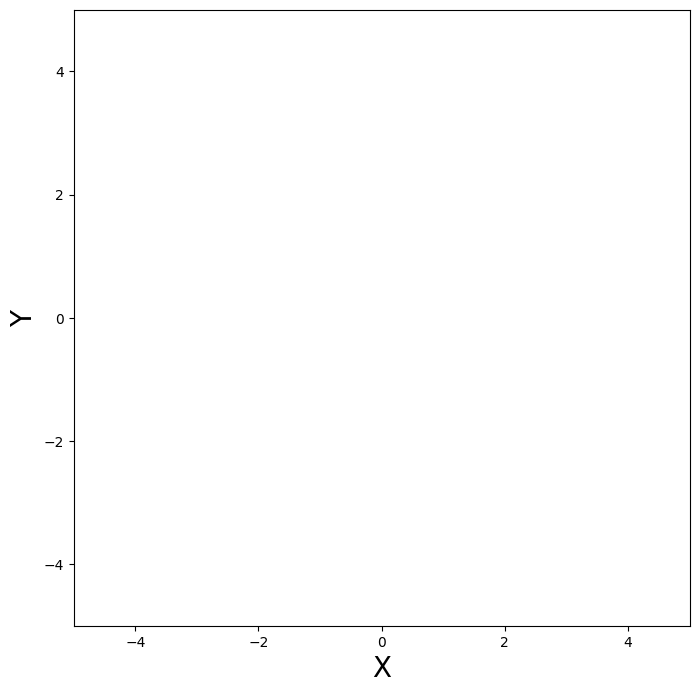

In [ ]:
world = World()
world.draw()

## 3.2.2 ロボットの姿勢と描画

In [ ]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [ ]:
class IdealRobot:                                        # fig:idealrobot
    def __init__(self, pose, color="black"):
        self.pose = pose        # 引数から姿勢の初期値を設定
        self.r = 0.2            # これは描画のためなので固定値
        self.color = color      # 引数から描画するときの色を設定

    def draw(self, ax):
      x, y, theta = self.pose #姿勢の変数を分解して3つの変数へ
      xn = x + self.r * math.cos(theta) #ロボットの鼻先のx座標
      yn = y + self.r* math.sin(theta) #ロボットの鼻先のy座標
      ax.plot([x,xn], [y,yn], color = self.color) #ロボットの向きを示す線分の描写
      c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
      ax.add_patch(c) #上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録


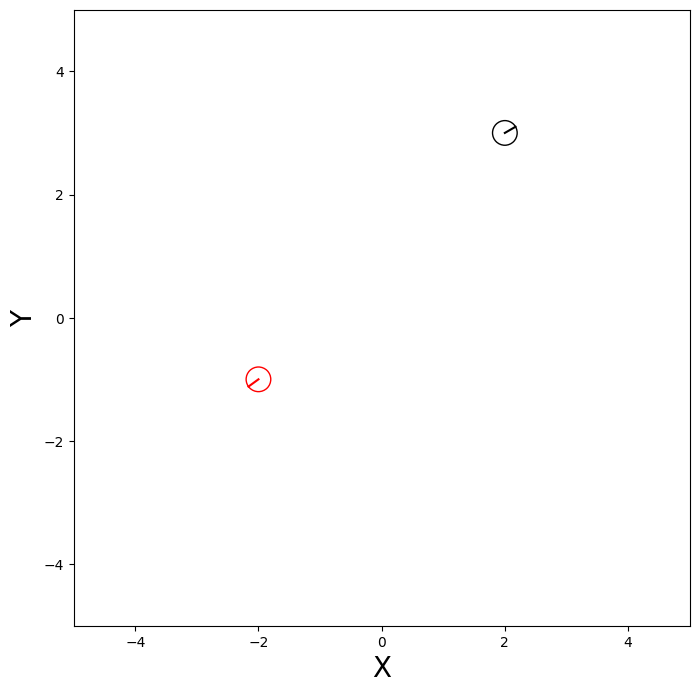

In [ ]:
world = World()

robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T , "red")
world.append(robot1)
world.append(robot2)

world.draw()

## 3.2.3 アニメーションの導入

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [ ]:
class World:
  def __init__(self, debug=False):
    self.objects = []
    self.debug = debug

  def append(self, obj):
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)

    elems = []
    time_increment = 0.1

    if self.debug:
      for i in range(1000): self.one_step(i, elems, ax)
    else:
      self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=10, interval=1000, repeat=False)
      return HTML(self.ani.to_jshtml())

  def one_step(self, i, elems, ax):
    while elems: elems.pop().remove()
    elems.append(ax.text(-4.4, 4.5, "t = " + str(i), fontsize=10))
    for obj in self.objects:
      obj.draw(ax, elems)

In [ ]:
class IdealRobot:
  def __init__(self, pose, color="black"):
    self.pose = pose
    self.r = 0.2
    self.color = color


  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

In [ ]:
world = World(debug=False)

robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T , "red")
world.append(robot1)
world.append(robot2)

world.draw()

<IPython.core.display.Javascript object>

## 3.2.4 ロボットの運動と状態方程式

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

状態遷移関数


*   clsはclassmethodのためのselfと同じ引数
*   nu->速度
*   omega-.角振動数
*   pose ->t=t-1での前の姿勢を示す



In [ ]:
class IdealRobot:
  def __init__(self, pose, color="black"):
    self.pose = pose
    self.r = 0.2
    self.color = color


  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])

In [ ]:
# 原点から0.1[m/s]で1[s]直進 ##          ### fig:using_state_transition（セル6まで）
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0,0,0]).T)

array([0.1, 0. , 0. ])

In [ ]:
## 原点から0.1[m/s], 10[deg/s]で9[s]移動 ##
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

## 3.2.5 エージェントの実装

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [ ]:
class Agent:
  def __init__(self, nu, omega):
    self.nu = nu
    self.omega = omega

  def decision(self, observation=None):
    return self.nu, self.omega

In [ ]:
class IdealRobot:
  def __init__(self, pose, agent = None, color="black"):
    self.pose = pose
    self.r = 0.2
    self.agent = agent
    self.color = color

    self.poses = [pose]

  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

    self.poses.append(self.pose) #以下追加。軌跡の描画
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color = "black")

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])



In [ ]:
world = World()                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()


<IPython.core.display.Javascript object>

In [ ]:
class World:
  def __init__(self, debug=False):
    self.objects = []
    self.debug = debug

  def append(self, obj):
    self.objects.append(obj)

  def draw(self):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=10)
    ax.set_ylabel("Y", fontsize=10)

    elems = []
    time_increment = 0.1

    if self.debug:
      for i in range(1000): self.one_step(i, elems, ax)
    else:
      self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=100, interval=1000, repeat=False)
      return HTML(self.ani.to_jshtml())

  def one_step(self, i, elems, ax):
    while elems: elems.pop().remove()
    elems.append(ax.text(-4.4, 4.5, "t = " + str(i), fontsize=10))
    for obj in self.objects:
      obj.draw(ax, elems)
      if hasattr(obj, "one_step"): obj.one_step(1.0) #追加

In [ ]:
class IdealRobot:
  def __init__(self, pose, agent = None, color="black"):
    self.pose = pose
    self.r = 0.2
    self.agent = agent
    self.color = color

    self.poses = [pose]

  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

    self.poses.append(self.pose)
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color = "black")

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])

  def one_step(self, time_interval):#追加
    if not self.agent: return
    nu, omega = self.agent.decision()
    self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [ ]:
class Agent:
  def __init__(self, nu, omega):
    self.nu = nu
    self.omega = omega

  def decision(self, observation=None):
    return self.nu, self.omega

In [ ]:
world = World()                                                                                                                       ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く）
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()


<IPython.core.display.Javascript object>

## 3.2.6 離散時刻の設定

In [ ]:
class World:        ### fig:world_init_add_timespan (1-6行目)
    def __init__(self, time_span, time_interval, debug=False): #time_span, time_intervalを追加
        self.objects = []
        self.debug = debug
        self.time_span = time_span                  # 追加
        self.time_interval = time_interval          # 追加

    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):            ### fig:world_draw_with_timespan (11, 22-36行目)
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に

        elems = []

        if self.debug:
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)  #固定値から変更
        else:
            ### FuncAnimationのframes, intervalを変更 ###
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            return HTML(self.ani.to_jshtml())

    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)    # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)                 # 変更

In [ ]:
world = World(10, 0.1, debug=False)   # 引数を追加         ### fig:add_args_world (1行目だけ)
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # コントローラを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

<IPython.core.display.Javascript object>

# 3.3 ロボットの観測

## 3.3.1 点ランドマークの設置

In [ ]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [ ]:
class World:        ### fig:world_init_add_timespan (1-6行目)
    def __init__(self, time_span, time_interval, debug=False): #time_span, time_intervalを追加
        self.objects = []
        self.debug = debug
        self.time_span = time_span                  # 追加
        self.time_interval = time_interval          # 追加

    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):            ### fig:world_draw_with_timespan (11, 22-36行目)
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に

        elems = []

        if self.debug:
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)  #固定値から変更
        else:
            ### FuncAnimationのframes, intervalを変更 ###
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            return HTML(self.ani.to_jshtml())

    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)    # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)                 # 変更

In [ ]:
class Agent:
  def __init__(self, nu, omega):
    self.nu = nu
    self.omega = omega

  def decision(self, observation=None):
    return self.nu, self.omega

In [ ]:
class IdealRobot:
  def __init__(self, pose, agent = None, color="black"):
    self.pose = pose
    self.r = 0.2
    self.agent = agent
    self.color = color

    self.poses = [pose]

  def draw(self, ax, elems):#実際はオブジェクトをelemsに追加する関数となってる
    x, y, theta = self.pose
    xn = x + self.r * math.cos(theta)
    yn = y + self.r * math.sin(theta)
    elems += ax.plot([x,xn], [y, yn], color = self.color) #elems += を追加
    c= patches.Circle(xy=(x, y), radius = self.r, fill=False, color = self.color) #c= を追加
    elems.append(ax.add_patch(c)) # elem.apendで包む

    self.poses.append(self.pose)
    elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color = "black")

  @classmethod
  def state_transition(cls, nu, omega, time, pose):
    t0 = pose[2]
    if math.fabs(omega) < 1e-10:
      return pose + np.array([nu*math.cos(t0),
                              nu*math.sin(t0),
                              omega]) * time
    else:
      return pose + np.array([nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                              nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                              omega*time])

  def one_step(self, time_interval):#追加
    if not self.agent: return
    nu, omega = self.agent.decision()
    self.pose = self.state_transition(nu, omega, time_interval, self.pose)

ここから新規

In [ ]:
class Landmark:
  def __init__(self, x, y):
    self.pos = np.array([x, y]).T
    self.id = None

  def draw(self, ax, elems):
    c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
    elems.append(c)
    elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

In [ ]:
class Map:
  def __init__(self):
    self.landmarks = []

  def append_landmark(self, landmark):
    landmark.id = len(self.landmarks)
    self.landmarks.append(landmark)

  def draw(self, ax, elems):
    for lm in self.landmarks: lm.draw(ax, elems)

In [ ]:
world = World(10, 0.1, debug=False)
landmark1 = Landmark(2, -2)
landmark2 = Landmark(3, 3)
map = Map()
map.append_landmark(landmark1)
map.append_landmark(landmark2)
world.append(map)
world.draw()

<IPython.core.display.Javascript object>

In [ ]:
world = World(10, 0.1, debug=False)           ### fig:execute_landmark_drawing（1, 3-8, 21行目）

### 地図を生成して3つランドマークを追加 ###
m = Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)                # worldに地図を登録

### ロボットを作る ###
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)

### アニメーション実行 ###
world.draw()

<IPython.core.display.Javascript object>

## 3.3.2 点ランドマークの観測

In [16]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [25]:
class World:        ### fig:world_init_add_timespan (1-5行目)
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span                  # 追加
        self.time_interval = time_interval          # 追加

    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):            ### fig:world_draw_with_timesapn (1, 10, 21-26, 28-34行目)
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に

        elems = []

        if self.debug:
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            return HTML(self.ani.to_jshtml())

    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)    # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)                 # 変更

In [18]:
class IdealRobot:            ### fig:robot_camera（1,2,8,28-29行目,49-53行目）
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加

    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:                    #追加
            self.sensor.draw(ax, elems, self.poses[-2])     #追加

    @classmethod
    def state_transition(self, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0),
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [19]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega

    def decision(self, observation=None):
        return self.nu, self.omega

In [20]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None

    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

In [21]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []

    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)    # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)

In [28]:
class IdealCamera:                      ### fig:camera2（1-4行目、6, 12-13行目, 26-32行目）
    def __init__(self, env_map, distance_range = (0.5, 6.0), direction_range = (-math.pi/3, math.pi/3)): #引数追加
        self.map = env_map
        self.lastdata = []

        self.distance_range = distance_range
        self.direction_range = direction_range

    def visible(self, polarpos):
        if polarpos is None:
            return False

        return ( polarpos[0] > 0 )

    def visible(self, polarpos):
        if polarpos is None:
            return False

        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
               and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]

    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z): #条件を追加
              observed.append((z, lm.id)) #インデント

        self.lastdata = observed
        return observed

    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T

    def draw(self, ax, elems, cam_pose):    # 追加 ###camera2_1
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")


In [43]:
world = World(10, 0.1)           ### fig:sensor_drawing (10-19行目)

### 地図を生成して3つランドマークを追加 ###
m = Map()
m.append_landmark(Landmark(2,-2))
m.append_landmark(Landmark(-1,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

### ロボットを作る ###
straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")  # robot3は消しました
world.append(robot1)
world.append(robot2)

### アニメーション実行 ###
world.draw()

<IPython.core.display.Javascript object>

# 3.4 コードの保存と再利用

In [16]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from IPython.display import HTML

In [40]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval

    def append(self,obj):
        self.objects.append(obj)

    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)

        elems = []

        if self.debug:
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            return HTML(self.ani.to_jshtml())

    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)

In [18]:
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加

    def draw(self, ax, elems):         ### call_agent_draw
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加
            self.agent.draw(ax, elems)

    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0),
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)

In [19]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega

    def decision(self, observation=None):
        return self.nu, self.omega

In [20]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None

    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

In [21]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []

    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)

In [22]:
class IdealCamera:
    def __init__(self, env_map, \
                 distance_range=(0.5, 6.0),
                 direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []

        self.distance_range = distance_range
        self.direction_range = direction_range

    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False

        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
                and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]

    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント

        self.lastdata = observed
        return observed

    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T

    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

In [45]:
if __name__ == '__main__':   ###name_indent これあるとアニメーションが起動しない
  world = World(30, 0.1)           ### fig:sensor_drawing (10-19行目

  ### 地図を生成して3つランドマークを追加 ###
  m = Map()
  m.append_landmark(Landmark(2,-2))
  m.append_landmark(Landmark(-1,-3))
  m.append_landmark(Landmark(3,3))
  world.append(m)

  ### ロボットを作る ###
  straight = Agent(0.2, 0.0)
  circling = Agent(0.2, 10.0/180*math.pi)
  robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
  robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")  # robot3は消しました
  world.append(robot1)
  world.append(robot2)

  ### アニメーション実行 ###
  world.draw()

<IPython.core.display.Javascript object>